## Informed V-JEPA
We investigate how HNN and LNN and VJEPA can learn and represent the physics behind a pendulum.
Steps :
- through openai gym we generate synthetic pendulum images. Each image is labeled by the physical state theta, theta dot. This is the ground truth for the learning and evaluation of physics/
- use utility funvtions to compute and plot the energy and true phase space trajectories of the pendulum, enabling visual checks for consistency and energy conservation.
- train vjepa to predict future image patches, i.e. latent states too, and track loss curves for both jepa objective and physics informed loss we came up with.
- We check the relationship between learned latent representations and true physical variables. We use linear regression to map latents to physical variables with metrics such as R2 and MSE.
- We have plots that show how well the model conserves energy over time and how close its latent space aligns with the true dynamics, ie. try to provide insights how the network encapsulates the underlying physics.

In [1]:
# necessary imports
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
import os
from PIL import Image, ImageDraw
import glob
import re

import gym

In [2]:
from models import *
from utils.train_functions import *
from utils.helper_functions import *
from utils.datasets import *
from utils.loading_functions import *
from utils.evaluation_functions import *
from utils.evaluation_metrics import *

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
batch_size = 32
ds = PendulumDataset(num_episodes=40, episode_length=40,
                         img_size=64, seq_len=3)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

Generating pendulum trajectories …


  0%|          | 0/40 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 40/40 [00:00<00:00, 241.80it/s]

Created 1520 windows (seq_len=3)


In [ ]:
if __name__ == "__main__":
    for mode in ["plain","hnn","lnn","hnn+lnn"]:
        cfg = TrainConfig.preset(mode)        # ← gets the right λ-weights
        run_mode(cfg, dl)
    print("\nFinished all experiments; compare logs in ./results/results_<mode>_dense.npz")

In [5]:
base_dir   = "./results_numpy"        # change if you moved them elsewhere
pattern    = "results_*_dense.npz"    # or "results_*.npz" if no suffix

logs = {}   # mode → dict(arrays + 'config')

for path in glob.glob(os.path.join(base_dir, pattern)):
    # extract mode between 'results_' and '_dense.npz'  (works for hnn+lnn)
    m = re.search(r"results_(.+?)_dense\.npz$", os.path.basename(path))
    if not m:
        print("skip", path); continue
    mode = m.group(1)

    npz  = np.load(path, allow_pickle=True)
    arrays = { k: npz[k] for k in npz.files if k != "config" }
    arrays = normalise_keys(arrays)
    arrays["config"] = npz["config"].item()

    logs[mode] = arrays
    print(f"loaded {mode:10} — epochs: {len(arrays['loss_total'])}")
    

loaded hnn+lnn    — epochs: 10
loaded lnn        — epochs: 10
loaded plain      — epochs: 10
loaded hnn        — epochs: 10


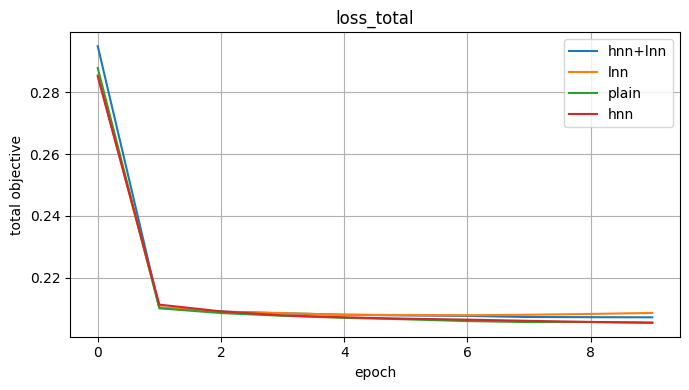

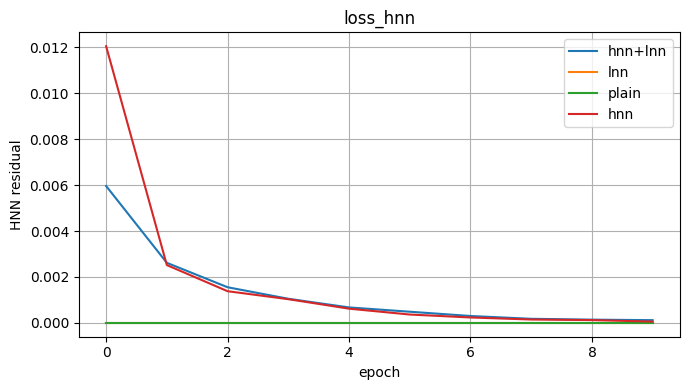

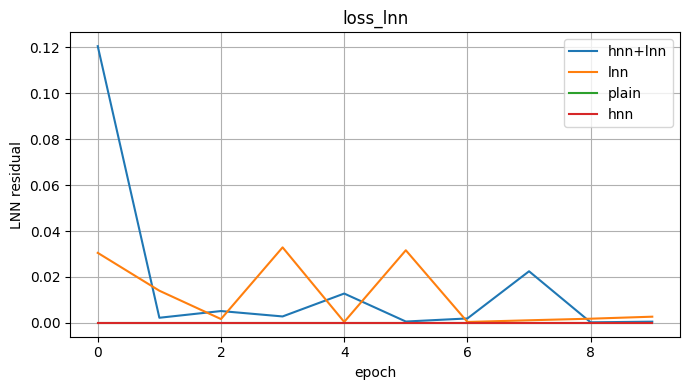

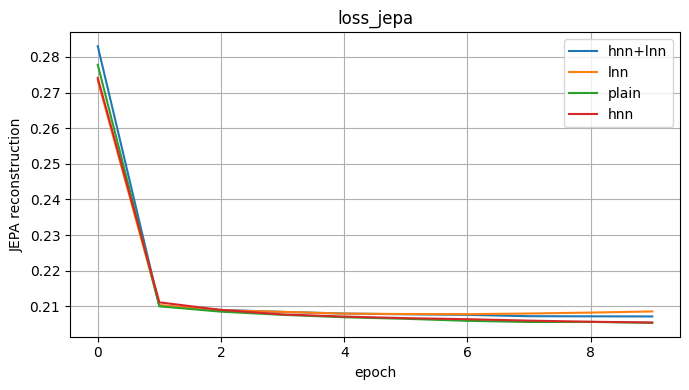

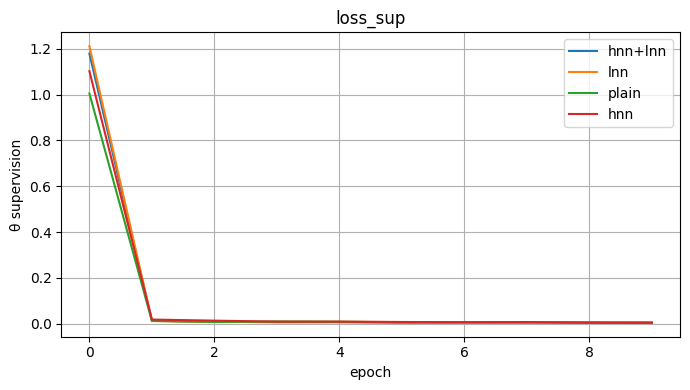

In [6]:
# ------------------------------------------------------------
#  Draw requested comparisons
# ------------------------------------------------------------

for key, label in metrics_to_plot:
    # plot only if *at least one* run recorded that key
    if any(key in rec for rec in logs.values()):
        plot_loss(key, logs, ylabel=label)          # plots every mode that has it
    else:
        print(f"[skip] no log contains '{key}'")

Generating pendulum trajectories …


  0%|          | 0/30 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 30/30 [00:00<00:00, 75.51it/s]


Created 5940 windows (seq_len=3)


rollout:   0%|          | 0/93 [00:00<?, ?it/s]/Users/panaschristou/Library/CloudStorage/OneDrive-Personal/Documents/Internships/MQube/physics_informed_machine_learning/utils/datasets.py:238: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  torch.from_numpy(self.frames[i]).float()


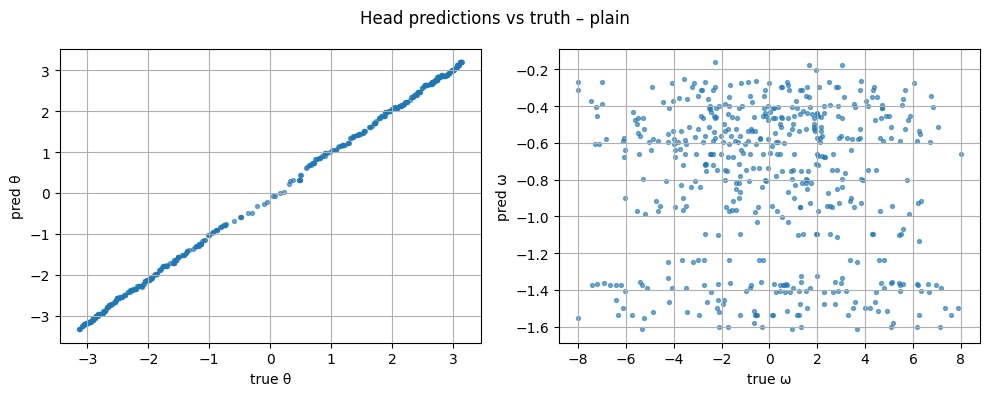

plain    → {'Δ_div': 0.1286066323518753, 'E_drift': 10.646839141845703, 'r2_theta': 0.9982693791389465, 'mse_theta': 0.008597509004175663, 'r2_omega': -0.10077619552612305, 'mse_omega': 13.627165794372559} (saved → ./metrics/metrics_plain_dense.json)


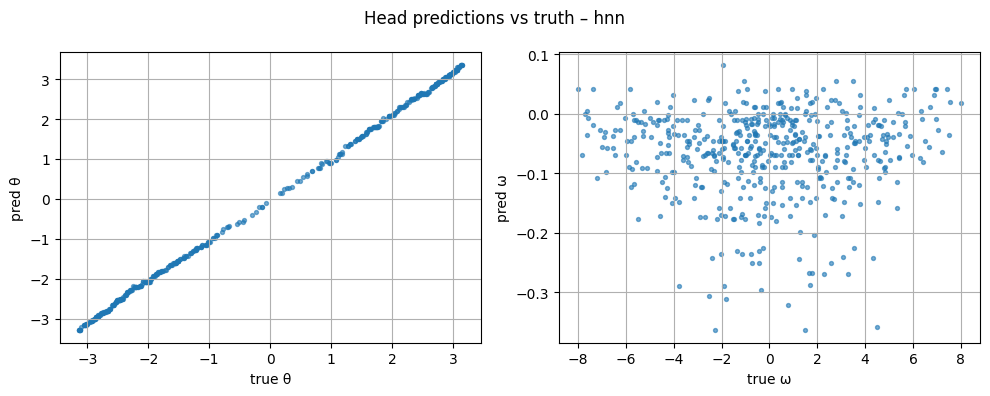

hnn      → {'Δ_div': 0.09535356611013412, 'E_drift': 1.3240388631820679, 'r2_theta': 0.9976850748062134, 'mse_theta': 0.011512278579175472, 'r2_omega': 0.00015175342559814453, 'mse_omega': 11.660670280456543} (saved → ./metrics/metrics_hnn_dense.json)


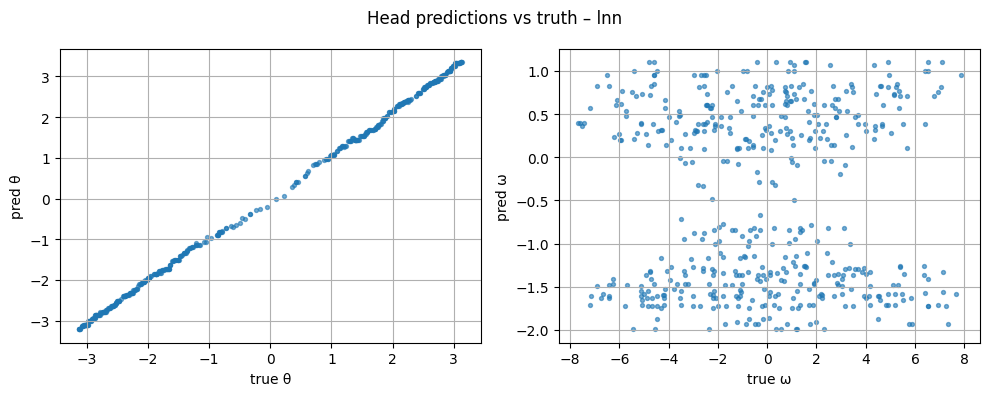

lnn      → {'Δ_div': 1.662096381187439, 'E_drift': 9.904672622680664, 'EL_res': 6.440562719944865e-05, 'r2_theta': 0.9970880746841431, 'mse_theta': 0.014263665303587914, 'r2_omega': -0.09645342826843262, 'mse_omega': 13.519548416137695} (saved → ./metrics/metrics_lnn_dense.json)


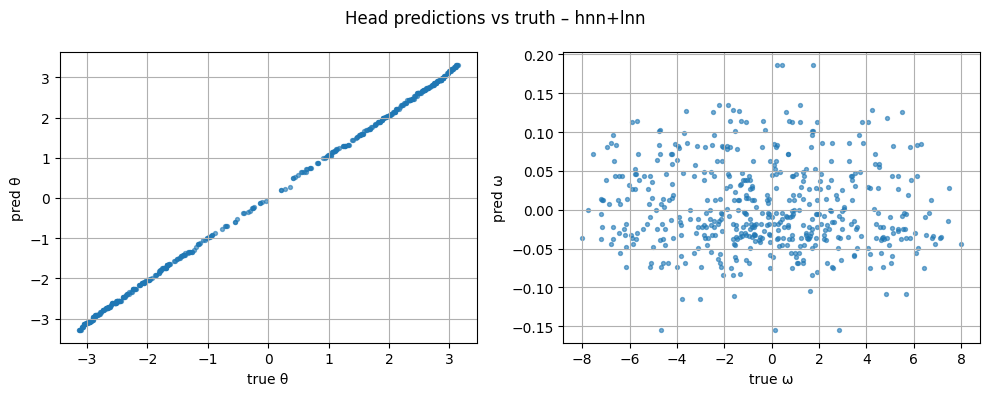

hnn+lnn  → {'Δ_div': 0.8412817716598511, 'E_drift': 5.755987644195557, 'EL_res': 1.3295075405039825e-05, 'r2_theta': 0.9986498951911926, 'mse_theta': 0.006819429341703653, 'r2_omega': -0.009381532669067383, 'mse_omega': 12.906837463378906} (saved → ./metrics/metrics_hnn+lnn_dense.json)

✓ combined metrics saved → ./metrics/metrics_all_dense.json


In [3]:
# a PendulumDataset identical to the one you used for training
eval_ds = PendulumDataset(num_episodes=30, episode_length=200,
                         img_size=64, seq_len=3)

metrics = evaluate_all_modes(
    modes        = ["plain", "hnn", "lnn", "hnn+lnn"],
    dataset      = eval_ds,
    cfg          = EvalConfig(),
    combine      = 'mean',   # example: 70 % HNN, 30 % LNN
    plot_scatter = True
)

In [4]:
# Testing the PendulumDataset
# Create a grid of initial conditions for the pendulum
# (theta, omega) pairs
grid = [(th, om)
        for th in np.linspace(-np.pi, np.pi, 15)
        for om in np.linspace(-5, 5, 9)]
ds = PendulumDataset(episode_length=300,
                     init_grid=grid,
                     random_action=False)

Generating pendulum trajectories …


  0%|          | 0/135 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 135/135 [00:01<00:00, 99.43it/s] 

Created 40230 windows (seq_len=3)


In [5]:
# ------------ physical & rollout constants --------------------------
DT, HORIZON = 0.05, 60          # 3 s rollout
g, l, m     = 9.81, 1.0, 1.0

eval_loader = DataLoader(
        PendulumDataset(episode_length=300, seq_len=3,
                        init_grid=[(th, om)
                                   for th in np.linspace(-np.pi, np.pi, 15)
                                   for om in np.linspace(-5, 5, 9)],
                        random_action=False),
        batch_size=64, shuffle=False
    )

Generating pendulum trajectories …


100%|██████████| 135/135 [00:01<00:00, 98.47it/s] 

Created 40230 windows (seq_len=3)


In [5]:
for MODE in ["plain", "hnn", "lnn", "hnn+lnn"]:
    evaluate_mode(
        mode        = MODE,
        eval_loader = eval_loader,
        horizon     = HORIZON,           # explicit, required
        dt          = DT,         # explicit, required
        m           = m, 
        l           = l,
        g           = g,  
        suffix      = "_dense",
        model_dir   = "./models",
        out_dir     = "./metrics_json"
    )

Found prefixed checkpoint: ./models/model_plain_dense.pt


rollout:   0%|          | 0/629 [00:00<?, ?it/s]/Users/panaschristou/Library/CloudStorage/OneDrive-Personal/Documents/Internships/MQube/physics_informed_machine_learning/dataset.py:126: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  imgs = [torch.from_numpy(self.frames[i]).float()


plain    → {'Δ_div': 0.1295238584280014, 'E_drift': 10.52688217163086} (saved → ./metrics_json/metrics_plain_dense.json)
Found prefixed checkpoint: ./models/model_hnn_dense.pt


hnn      → {'Δ_div': 0.10257886350154877, 'E_drift': 1.4876724481582642} (saved → ./metrics_json/metrics_hnn_dense.json)
Found prefixed checkpoint: ./models/model_lnn_dense.pt


lnn      → {'Δ_div': 1.8351854085922241, 'E_drift': 9.947497367858887, 'EL_res': 7.486382673960179e-05} (saved → ./metrics_json/metrics_lnn_dense.json)
Found prefixed checkpoint: ./models/model_hnn+lnn_dense.pt


hnn+lnn  → {'Δ_div': 0.09030360728502274, 'E_drift': 2.611436367034912, 'EL_res': 6.875476628920296e-06} (saved → ./metrics_json/metrics_hnn+lnn_dense.json)
